In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import sys
sys.path.append("../")
import nextgems as ng

In [2]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [3]:
print(list(cat.IFS['IFS_4.4-FESOM_5-cycle3']))

['2D_1h_native', '3D_1h6h_native', '2D_monthly_native', '3D_monthly_native', '2D_monthly_0.25deg', '3D_monthly_0.25deg', '2D_1h_0.25deg', '3D_1h6h_0.25deg', '2D_monthly_1deg', '3D_monthly_1deg', '2D_1h_1deg', '3D_1h6h_1deg', 'WAM_1h_native']


In [4]:
data = cat.IFS['IFS_4.4-FESOM_5-cycle3']['2D_1h_native'].to_dask()

In [5]:
data

<xarray.Dataset>
Dimensions:  (time: 43394, value: 26306560)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2025-01-01
Dimensions without coordinates: value
Data variables: (12/59)
    100u     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2t       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ...       ...
    tisr     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    tp       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    tsr      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ttr      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    z        (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    zos      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [6]:
model_lon = data.lon.values
model_lat = data.lat.values
nonan = ~((np.isnan(model_lon)) | (np.isnan(model_lat)))
lat_nonan = model_lat[nonan]
lon_nonan = model_lon[nonan]
lon_nonan = np.where(lon_nonan>180, lon_nonan-360, lon_nonan)
points_ifs = np.vstack((lon_nonan, lat_nonan)).T

In [7]:
bbox = [-20, 30, 30, 70]

Check how the map boundaries will look like

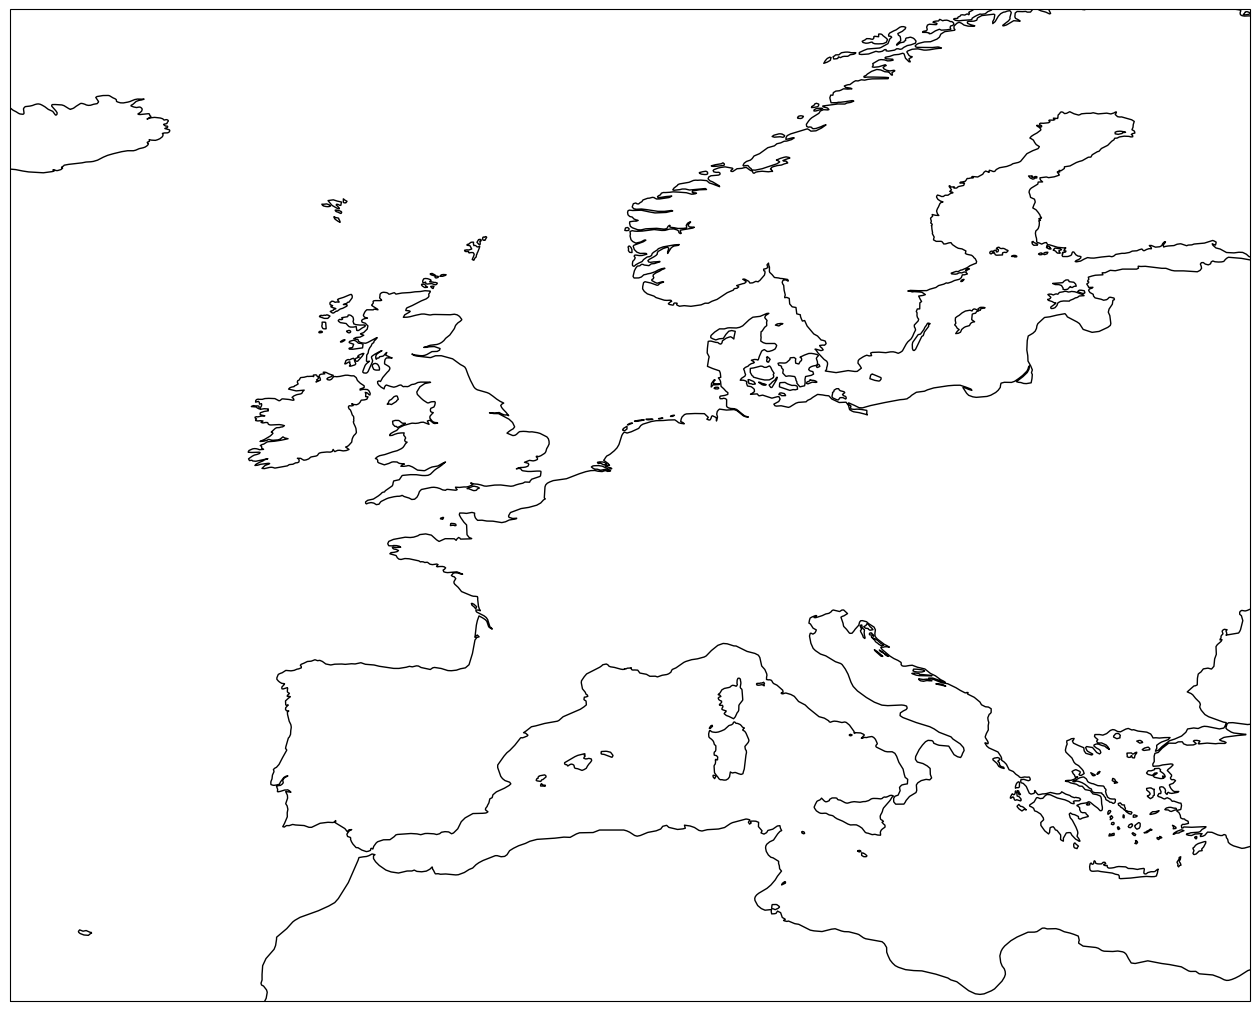

In [8]:
fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.PlateCarree()),
            constrained_layout=True,
            figsize=(15,10),
        )
ax.set_extent(bbox, crs=ccrs.PlateCarree())
ax.coastlines()

In [9]:
x, y, lon2, lat2 = ng.projected_grid_to_platecarree_pyproj(bbox, [1000, 1000], projection="World_Plate_Carree", n_points=100)

In [10]:
distances, inds = ng.create_indexes_and_distances(model_lon, model_lat, lon2, lat2, k=1, workers=10)

In [11]:
rho = 1.225  # air density at sea level (15C)
diameter = 100  # rotor diameter in meters (change this to your value)
A = np.pi * (diameter / 2)**2  # area swept by wind turbine
height = 100  # height of turbine in meters (change this to your value)
alpha = 0.143  # wind shear exponent
capacity_factor = 0.35  # capacity factor of turbine
rated_power = 3.0  # rated power of your turbine in MW

cut_in_speed = 3.0  # m/s, adjust as needed
rated_speed = 12.0  # m/s, adjust as needed
cut_out_speed = 25.0  # m/s, adjust as needed

In [12]:
timestep = 1106
data_sample = data['10u'][timestep,:]
data_sample2 = data['10v'][timestep,:]
wind_speed_10m = np.sqrt(data_sample**2 + data_sample2**2).compute()
wind_speed = wind_speed_10m * (height / 10) ** alpha

In [13]:
P = xr.where(wind_speed < cut_in_speed, 0, wind_speed)
P = xr.where((wind_speed >= cut_in_speed) & (wind_speed < rated_speed), 
             np.minimum(0.5 * rho * A * wind_speed**3, rated_power * 1e6), P)
P = xr.where((wind_speed >= rated_speed) & (wind_speed < cut_out_speed), 
             rated_power * 1e6, P)  # rated power in Watts
P = xr.where(wind_speed >= cut_out_speed, 0, P)

In [14]:
radius_of_influence=5000
data_interpolated =P.values[inds]
data_interpolated[distances >= radius_of_influence] = np.nan
data_interpolated = data_interpolated.reshape(lon2.shape)
data_interpolated = np.ma.masked_invalid(data_interpolated)

In [15]:
data_interpolated.max()

3000000.0

In [16]:
from matplotlib import cm

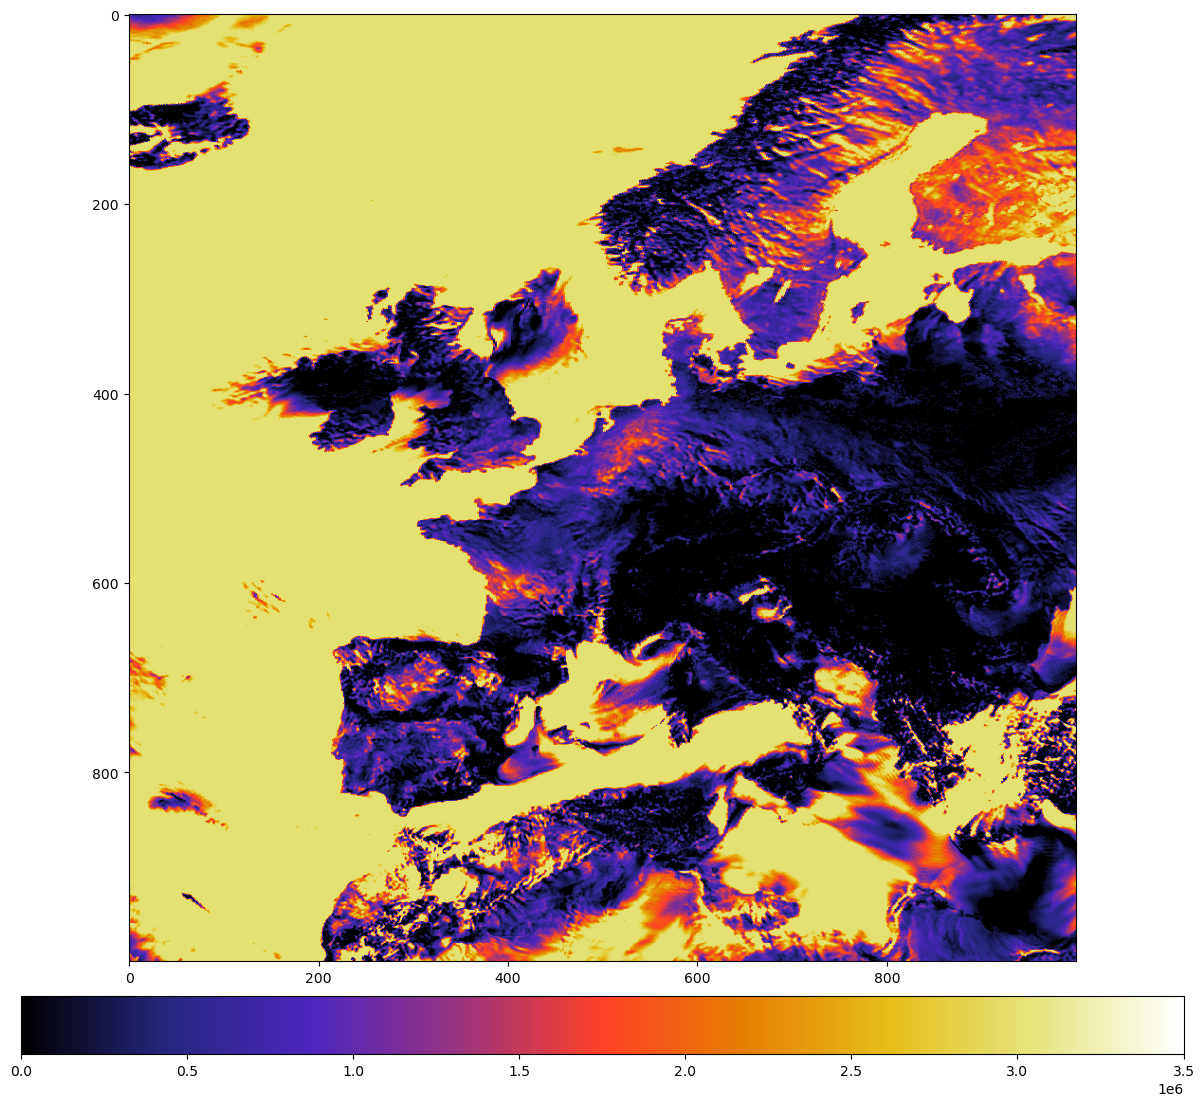

In [17]:
plt.figure(figsize=(15,15))
# plt.imshow(np.flipud(data_interpolated[200:500, 500:600]), vmin=0, vmax=300000)
plt.imshow(np.flipud(data_interpolated), vmin=0, vmax=3500000, cmap=cm.CMRmap)
plt.colorbar(orientation="horizontal", pad=0.03)

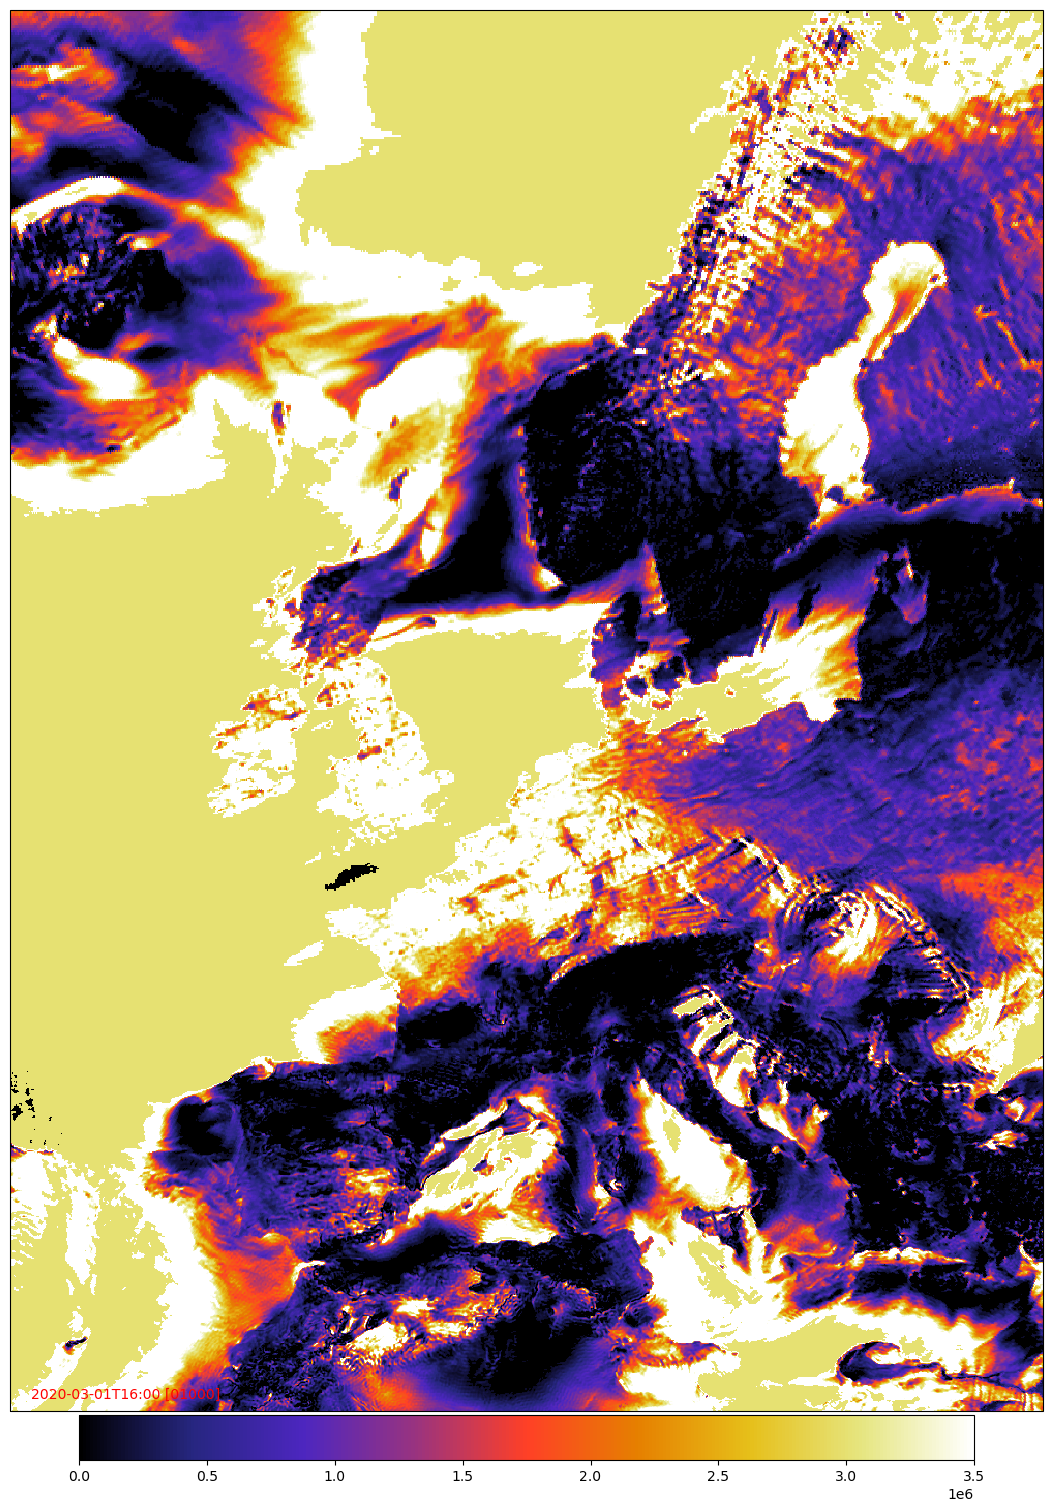

In [23]:
for i in range(1000, 1001):
    data_sample = data['10u'][i,:]
    data_sample2 = data['10v'][i,:]
    wind_speed_10m = np.sqrt(data_sample**2 + data_sample2**2).compute()
    wind_speed = wind_speed_10m * (height / 10) ** alpha
    
    P = xr.where(wind_speed < cut_in_speed, 0, wind_speed)
    P = xr.where((wind_speed >= cut_in_speed) & (wind_speed < rated_speed), 
                 0.5 * rho * A * wind_speed**3 , P)
    P = xr.where((wind_speed >= rated_speed) & (wind_speed < cut_out_speed), 
                 rated_power * 1e6, P)  # rated power in Watts
    P = xr.where(wind_speed >= cut_out_speed, 0, P)
    

    radius_of_influence=5000
    data_interpolated =P.values[inds]
    data_interpolated[distances >= radius_of_influence] = np.nan
    data_interpolated = data_interpolated.reshape(lon2.shape)
    data_interpolated = np.ma.masked_invalid(data_interpolated)

    fig, ax = plt.subplots(
                1,
                1,
                subplot_kw=dict(projection=ccrs.Mercator()),
                constrained_layout=True,
                figsize=(15,15),
            )
    ax.set_extent(bbox, crs=ccrs.PlateCarree())
    data_levels = np.linspace(-0.5, 0.5, 31)
    colormap = cm.CMRmap
    image = ax.pcolormesh(
                    lon2,
                    lat2,
                    data_interpolated,
                    vmin=0,
                    vmax=3500000,
                    # levels=data_levels,
                    transform=ccrs.PlateCarree(),
                    cmap=colormap,
                    # extend="both",
                )
    data_levels2=np.linspace(240,310, 41)
    textxy = [-19, 30.5]
    strtime = data_sample.time.values.astype('str')[:16]
    ax.text(textxy[0], textxy[1], f'{strtime} [{str(i).zfill(5)}]', {'size':10, 'color':"red"}, zorder=11, transform=ccrs.PlateCarree())
    plt.colorbar(image, orientation='horizontal', pad=0.003, shrink=0.6)
    # uncomment those lines to create figures for animation
    # plt.savefig(f'/work/bm1344/AWI/Cycle3/movies/energy_production/{str(i).zfill(5)}.png')
    # plt.close(fig)
    # print(i)